<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Intro_to_peft_lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune large models using 🤗 `peft` adapters, `transformers` & `bitsandbytes`

In this tutorial we will cover how we can fine-tune large language models using the very recent `peft` library and `bitsandbytes` for loading large models in 8-bit.
The fine-tuning method will rely on a recent method called "Low Rank Adapters" (LoRA), instead of fine-tuning the entire model you just have to fine-tune these adapters and load them properly inside the model. 
After fine-tuning the model you can also share your adapters on the 🤗 Hub and load them very easily. Let's get started!

## Install Requirements

In [1]:
!pip install bitsandbytes==0.38.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.1 MB/s eta 0:00:00


In [2]:
!pip install -qU datasets accelerate loralib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.6 MB/s eta 0:00:00


In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.8 MB/s eta 0:00:00


In [4]:
!pip install -q git+https://github.com/lvwerra/trl.git

  Preparing metadata (setup.py) ... done


In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           83Gi       1.2Gi        77Gi       4.0Mi       4.5Gi        81Gi
Swap:            0B          0B          0B


In [4]:
!nvidia-smi

Fri Apr 28 12:57:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Create PEFT-LoRA Model (Seq2Seq)

In [4]:
from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_model, LoraConfig,TaskType


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

In [6]:
classical_model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

In [7]:
classical_model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

* r indicates rank
* use of dropout common regularization technique to imporove generalization and prevent overfittng

In [9]:
peft_config = LoraConfig(peft_type = "LORA",
                         task_type="SEQ_2_SEQ_LM",
                         r=8,
                         lora_alpha=32,
                         target_modules=["q","v"],
                         lora_dropout=0.01)

In [10]:
peft_lora_model = get_peft_model(classical_model,peft_config)

In [11]:
peft_lora_model.print_trainable_parameters()

trainable params: 884736 || all params: 223788288 || trainable%: 0.3953450861557152


In [12]:
peft_lora_model

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=768, out_features=768, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=768, bias=False)
                    )
                  )
                  (k): Linear(in_features=768, out_features=768, bias=False)


In [13]:
model_name_or_path = "bigscience/mt0-large"
tokenizer_name_or_path = "bigscience/mt0-large"
model2 = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model2

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 1024)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 1024)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=Fals

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-6.7b", 
    load_in_8bit=True, 
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Post-processing on the model
Finally, we need to apply some post-processing on the 8-bit model to enable training, let's freeze all our layers, and cast the layer-norm in float32 for stability. We also cast the output of the last layer in float32 for the same reasons.

In [7]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [12]:
model.lm_head

CastOutputToFloat(
  (0): Linear(in_features=4096, out_features=50272, bias=False)
)

In [10]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50272, 4096, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 4096)
          (final_layer_norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-31): 32 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=True)
                (v_proj): Linear8bitLt(
                  in_features=4096, out_features=4096, bias=True
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=4096, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (defau

In [9]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

### Apply LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

In [10]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)


In [12]:
print_trainable_parameters(model)

trainable params: 8388608 || all params: 6666862592 || trainable%: 0.12582542214183376


In [13]:
model.print_trainable_parameters()

trainable params: 8388608 || all params: 6666862592 || trainable%: 0.12582542214183376


In [14]:
import transformers
from datasets import load_dataset
data = load_dataset("Abirate/english_quotes")
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)

trainer = transformers.Trainer(
    model=model, 
    train_dataset=data['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4, 
        gradient_accumulation_steps=4,
        warmup_steps=100, 
        max_steps=200, 
        learning_rate=2e-4, 
        fp16=True,
        logging_steps=1, 
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/Abirate___json/Abirate--english_quotes-6e72855d06356857/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,2.364400
2,2.200400
3,2.299600
4,2.185900
5,1.874500
6,2.307800
7,2.192700
8,2.446400
9,2.458100
10,2.018500


TrainOutput(global_step=200, training_loss=1.9312904274463654, metrics={'train_runtime': 2131.448, 'train_samples_per_second': 1.501, 'train_steps_per_second': 0.094, 'total_flos': 1.148636791701504e+16, 'train_loss': 1.9312904274463654, 'epoch': 1.28})

at 36 iterations
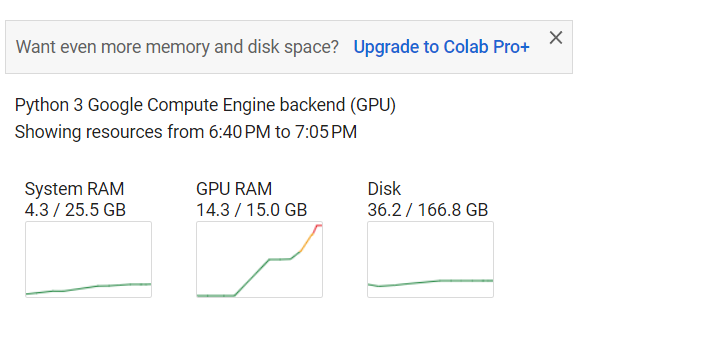

at 62 nd iteration
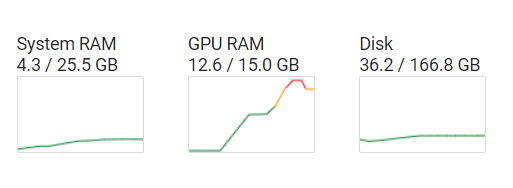

at 146th Iteration
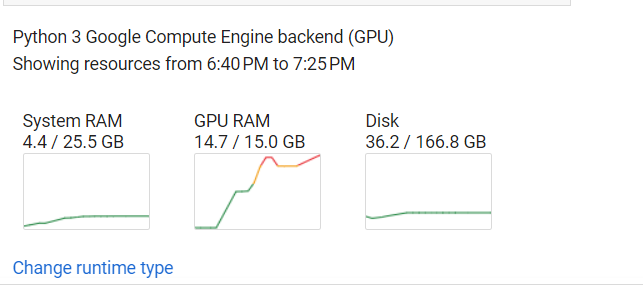

## Save the Model for inference

In [19]:
from huggingface_hub import notebook_login
notebook_login()

In [22]:
from google.colab import drive 
drive.mount("/content/drive")

In [27]:
model.push_to_hub("Plaban81/fine_tuned_peft_model",use_auth_token=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:781 in push_to_hub             │
│                                                                                                  │
│    778 │   │   │   files_timestamps = self._get_files_timestamps(work_dir)                       │
│    779 │   │   │                                                                                 │
│    780 │   │   │   # Save all files.                                                             │
│ ❱  781 │   │   │   self.save_pretrained(work_dir, max_shard_size=max_shard_size)                 │
│    782 │   │   │                                                                                 │
│    783 │   │   │   return self._upload_modified_files(                                           │
│    784 │   │   │   │   work_dir,                                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/peft_model.py:125 in save_pretrained                │
│                                                                                                  │
│    122 │   │                                                                                     │
│    123 │   │   for adapter_name, peft_config in self.peft_config.items():                        │
│    124 │   │   │   # save only the trainable weights                                             │
│ ❱  125 │   │   │   output_state_dict = get_peft_model_state_dict(                                │
│    126 │   │   │   │   self, state_dict=kwargs.get("state_dict", None), adapter_name=adapter_na  │
│    127 │   │   │   )                                                                             │
│    128 │   │   │   output_dir = os.path.join(save_directory, adapter_name) if adapter_name != "  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:32 in                        │
│ get_peft_model_state_dict                                                                        │
│                                                                                                  │
│    29 │   """                                                                                    │
│    30 │   config = model.peft_config[adapter_name]                                               │
│    31 │   if state_dict is None:                                                                 │
│ ❱  32 │   │   state_dict = model.state_dict()                                                    │
│    33 │   if config.peft_type in (PeftType.LORA, PeftType.ADALORA):                              │
│    34 │   │   # to_return = lora_state_dict(model, bias=model.peft_config.bias)                  │
│    35 │   │   # adapted from `https://github.com/microsoft/LoRA/blob/main/loralib/utils.py`      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1818 in state_dict            │
│                                                                                                  │
│   1815 │   │   self._save_to_state_dict(destination, prefix, keep_vars)                          │
│   1816 │   │   for name, module in self._modules.items():                                        │
│   1817 │   │   │   if module is not None:                                                        │
│ ❱ 1818 │   │   │   │   module.state_dict(destination=destin

In [23]:
model.save_pretrained("/content/drive/MyDrive/Fine_tuned") 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/peft_model.py:125 in save_pretrained                │
│                                                                                                  │
│    122 │   │                                                                                     │
│    123 │   │   for adapter_name, peft_config in self.peft_config.items():                        │
│    124 │   │   │   # save only the trainable weights                                             │
│ ❱  125 │   │   │   output_state_dict = get_peft_model_state_dict(                                │
│    126 │   │   │   │   self, state_dict=kwargs.get("state_dict", None), adapter_name=adapter_na  │
│    127 │   │   │   )                                                                             │
│    128 │   │   │   output_dir = os.path.join(save_directory, adapter_name) if adapter_name != "  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:32 in                        │
│ get_peft_model_state_dict                                                                        │
│                                                                                                  │
│    29 │   """                                                                                    │
│    30 │   config = model.peft_config[adapter_name]                                               │
│    31 │   if state_dict is None:                                                                 │
│ ❱  32 │   │   state_dict = model.state_dict()                                                    │
│    33 │   if config.peft_type in (PeftType.LORA, PeftType.ADALORA):                              │
│    34 │   │   # to_return = lora_state_dict(model, bias=model.peft_config.bias)                  │
│    35 │   │   # adapted from `https://github.com/microsoft/LoRA/blob/main/loralib/utils.py`      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1818 in state_dict            │
│                                                                                                  │
│   1815 │   │   self._save_to_state_dict(destination, prefix, keep_vars)                          │
│   1816 │   │   for name, module in self._modules.items():                                        │
│   1817 │   │   │   if module is not None:                                                        │
│ ❱ 1818 │   │   │   │   module.state_dict(destination=destination, prefix=prefix + name + '.', k  │
│   1819 │   │   for hook in self._state_dict_hooks.values():                                      │
│   1820 │   │   │   hook_result = hook(self, destination, prefix, local_metadata)                 │
│   1821 │   │   │   if hook_result is not None:                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1818 in state_dict            │
│                                                                                                  │
│   1815 │   │   self._save_to_state_dict(destination, prefix, keep_vars)                          │
│   1816 │   │   for name, module in self._modules.items():                                        │
│   1817 │   │   │   if module is not None:                                                        │
│ ❱ 1818 │   │   │   │   module.state_dict(destination=destin

## Inference

In [25]:
batch = tokenizer("Two things are infinite: ", return_tensors='pt')

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=50).to('cuda')

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1443: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")

## Experiments

In [13]:
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed

In [14]:
from peft import LoraConfig, get_peft_model,prepare_model_for_int8_training
model = prepare_model_for_int8_training(model, output_embedding_layer_name="embed_out", layer_norm_names=[])

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 8388608 || all params: 6666862592 || trainable%: 0.12582542214183376


In [16]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(peft_model,device_map="auto")

## Data

In [17]:
import transformers
from datasets import load_dataset
data = load_dataset("Abirate/english_quotes")
print(data['train'][0])
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/Abirate___json/Abirate--english_quotes-6e72855d06356857/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

{'quote': '“Be yourself; everyone else is already taken.”', 'author': 'Oscar Wilde', 'tags': ['be-yourself', 'gilbert-perreira', 'honesty', 'inspirational', 'misattributed-oscar-wilde', 'quote-investigator']}


Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

## Training

In [20]:
trainer = transformers.Trainer(
    model=model, 
    train_dataset=data['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4, 
        gradient_accumulation_steps=4,
        warmup_steps=100, 
        max_steps=200, 
        learning_rate=2e-4, 
        fp16=True,
        logging_steps=1, 
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:403 in __init__                  │
│                                                                                                  │
│    400 │   │   │   │   │   " the examples in https://github.com/huggingface/peft for more detai  │
│    401 │   │   │   │   )                                                                         │
│    402 │   │   │   else:                                                                         │
│ ❱  403 │   │   │   │   raise ValueError(                                                         │
│    404 │   │   │   │   │   "The model you want to train is loaded in 8-bit precision.  if you w  │
│    405 │   │   │   │   │   " model, please make sure that you have installed `bitsandbytes>=0.3  │
│    406 │   │   │   │   )                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: The model you want to train is loaded in 8-bit precision.  if you want to fine-tune an 8-bit model, 
please make sure that you have installed `bitsandbytes>=0.37.0`.